<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/pepijn/cifar10_model_kernel3_kernel8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

In [3]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(128),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Extracting /data/cifar10/train/cifar-10-python.tar.gz to /data/cifar10/train


Extracting /data/cifar10/test/cifar-10-python.tar.gz to /data/cifar10/test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


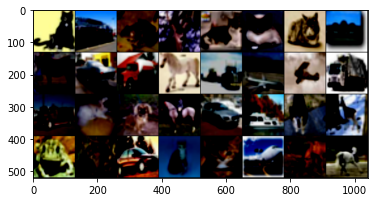

In [4]:
def showimage(image):
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)

images, labels = next(iter(trainloader))
showimage(torchvision.utils.make_grid(images))

In [5]:
# kernel size = 8
class MyModel8(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=8, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=8, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=8, stride=1, padding=1)
        self.fc1 = nn.Linear(11 * 11 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model8 = MyModel8()
model8

MyModel(
  (conv1): Conv2d(3, 8, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7744, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
)

In [6]:
# kernel size = 3
class MyModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model3 = MyModel3()
model3

MyModel(
  (conv1): Conv2d(3, 8, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7744, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
)

In [29]:
def train(model, optimizer, trainloader, testloader, criterion=nn.CrossEntropyLoss(), epochs=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(device)

    lowest_testloss = np.Inf

    for epoch in range(epochs):

        # training
        trainloss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(images)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()
        print(f"Epoch {epoch}, Training loss: {trainloss}")

        # validation
        testloss = 0
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                out = model(images)
                loss = criterion(out, labels)
                testloss += loss
        print(f"Epoch {epoch}, Validation loss: {testloss}")

        if testloss > lowest_testloss: 
            break
        lowest_testloss = testloss
    
    # final accuracy
    totacc = 0
    n = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            out = model(images)
            topv, topi = torch.topk(out, 1, dim=1)
            labels.resize_(*topi.shape)
            eq = topi == labels
            acc = torch.mean(eq.type(torch.FloatTensor))
            totacc += acc.item()
            n += 1
    totacc /= n
    print(f"The final total accuracy is: {totacc * 100}")

In [39]:
# kernel size = 8
start = timer()
train(model8, 
      optim.SGD(params=model.parameters(), lr=0.005),
      trainloader, 
      testloader, epochs=10)
end = timer()
print(end-start)


cuda
Epoch 0, Training loss: 2379.696984231472
Epoch 0, Validation loss: 2327.603759765625
Epoch 1, Training loss: 2163.5003519058228
Epoch 1, Validation loss: 2024.8846435546875
Epoch 2, Training loss: 1954.5557473301888
Epoch 2, Validation loss: 1782.1900634765625
Epoch 3, Training loss: 1768.3429863452911
Epoch 3, Validation loss: 1603.15771484375
Epoch 4, Training loss: 1596.3832804858685
Epoch 4, Validation loss: 1422.7137451171875
Epoch 5, Training loss: 1428.5430053770542
Epoch 5, Validation loss: 1240.978271484375
Epoch 6, Training loss: 1270.8561427891254
Epoch 6, Validation loss: 1092.4261474609375
Epoch 7, Training loss: 1108.2045800983906
Epoch 7, Validation loss: 908.419189453125
Epoch 8, Training loss: 945.7838073074818
Epoch 8, Validation loss: 796.86376953125
Epoch 9, Training loss: 782.3838985934854
Epoch 9, Validation loss: 615.9323120117188
The final total accuracy is: 86.69825655790147
778.009661047


cuda
Epoch 0, Training loss: 3537.0388122797012
Epoch 0, Validation loss: 3241.00732421875
Epoch 1, Training loss: 2938.9077928066254
Epoch 1, Validation loss: 2626.0263671875
The final total accuracy is: 40.34908829174665
197.78902494299996

In [41]:
# kernel size = 3
start = timer()
train(model3, 
      optim.SGD(params=model.parameters(), lr=0.005),
      trainloader, 
      testloader, epochs=10)
end = timer()
print(end-start)


cuda
Epoch 0, Training loss: 3578.371309518814
Epoch 0, Validation loss: 3454.953857421875
Epoch 1, Training loss: 3015.80275285244
Epoch 1, Validation loss: 2717.365966796875
Epoch 2, Training loss: 2598.3815730810165
Epoch 2, Validation loss: 2432.9716796875
Epoch 3, Training loss: 2386.716751933098
Epoch 3, Validation loss: 2263.7333984375
Epoch 4, Training loss: 2219.303647518158
Epoch 4, Validation loss: 2226.06640625
Epoch 5, Training loss: 2036.8343121409416
Epoch 5, Validation loss: 2018.4537353515625
Epoch 6, Training loss: 1886.2744285464287
Epoch 6, Validation loss: 1833.951904296875
Epoch 7, Training loss: 1755.89114433527
Epoch 7, Validation loss: 1643.8228759765625
Epoch 8, Training loss: 1635.2103438973427
Epoch 8, Validation loss: 1604.318603515625
Epoch 9, Training loss: 1521.239524513483
Epoch 9, Validation loss: 1389.611328125
The final total accuracy is: 68.80998080614204
747.8660239769997


In [ ]:
# load model
state_dict = torch.load("ninetynine.model")
model.load_state_dict(state_dict)

<All keys matched successfully>